# RLS Demo

Demo for unsupervised brute force shaplets searching for anomaly detection 

In [43]:
import sys
sys.path.append('../')

import numpy as np
import random

from tslearn.datasets import CachedDatasets, UCR_UEA_datasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance

from src.preprocessing_anomaly import preprocessing_anomaly
from src.SVDD.SVDD import SVDD
from src.util import Normalizer
from src.searching.RLS import RLS_extractor

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.svm import OneClassSVM

import matplotlib.pyplot as plt
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"


## Set up the dataset

### Load the data

Download the data (if needed):

In [44]:
# data_name = "Trace"
# X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(data_name)
# np.save(f'../demo/data/{data_name}_train', X_train)
# np.save(f'../demo/data/{data_name}_train_labels', y_train)
# np.save(f'../demo/data/{data_name}_test', X_test)
# np.save(f'../demo/data/{data_name}_test_labeles', y_test)

Or load the data from saved numpy arrays:

In [45]:
data_name = "Trace"
X_train = np.load(f'../demo/data/{data_name}_train.npy')
y_train = np.load(f'../demo/data/{data_name}_train_labels.npy')
X_test = np.load(f'../demo/data/{data_name}_test.npy')
y_test = np.load(f'../demo/data/{data_name}_test_labeles.npy')

### Preprocessing

#### Get statistics of the entire data:

In [46]:
print(f'Shape of training data: {X_train.shape}')
print(f'Shape of test data: {X_test.shape}')
print(f'The different classes: {set(y_train)}')

X_total = np.concatenate((X_train, X_test), axis=0)
y_total = np.concatenate((y_train, y_test), axis=0)
print(f'Shape of the total data: {X_total.shape}')

#### check if one class is predominant
obs_perclass = [len(y_total[y_total==i]) for i in set(y_total)]
print(f'Number of total samples in each class: {obs_perclass}')

Shape of training data: (100, 275, 1)
Shape of test data: (100, 275, 1)
The different classes: {1, 2, 3, 4}
Shape of the total data: (200, 275, 1)
Number of total samples in each class: [50, 50, 50, 50]


Use LabelEncoder in case the name of the labels are strings:

In [47]:
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.fit_transform(y_test)
# print('The positions are the new labels', le.classes_)


Plot one sample per class (first channel in case multivariate):

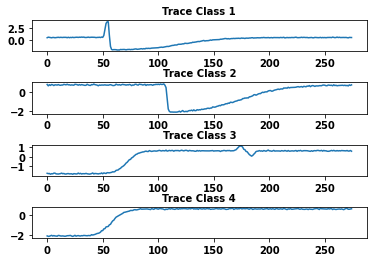

In [48]:
n_class = len(obs_perclass)

fig, ax = plt.subplots(n_class,)

# NOTE: modify if the labels start from 0 or 1
for i in range(n_class):
    ts = X_train[y_train==i+1][0,:,0]
    ax[i].set_title(f'{data_name} Class {i+1}', fontsize=10, fontweight="bold")
    ax[i].plot(ts)
plt.subplots_adjust(hspace=1)
plt.show()

#### Create anomaly detection dataset:

- First the train and test set are merged together
- A proportion "normal_prop" of time series from "normal_class" is selected randomly in the train set
- A proportion "alpha" of the latter set of normal train series is selected randomly from the other classes to represent the anomalies in the train set
- All the other series go in the test set

In [49]:
# Set seed for determinism
np.random.seed(0)

# keep only certain classes
X_train = X_train[np.logical_or(y_train==3, y_train==4)]
y_train = y_train[np.logical_or(y_train==3, y_train==4)]

X_test = X_test[np.logical_or(y_test==3, y_test==4)]
y_test = y_test[np.logical_or(y_test==3, y_test==4)]

# Set up anomaly detection dataset

normal_class = 4 # choose the normal class
normal_prop = 0.8 # proportion of normal samples that go in train set
alpha = 0.05 # proportion of anomalies wrt normal 
X_train_anomaly, y_train_anomaly, X_test_anomaly, y_test_anomaly = preprocessing_anomaly(X_train, y_train, X_test, y_test, alpha, normal_class=normal_class, normal_prop=normal_prop)


Get statistics of the anomaly detection dataset:

In [50]:
N, Q, n_channels = X_train_anomaly.shape
print(f'{data_name} dataset')
print(f'number train ts is {N}, each of length {Q}')
print(f'They belong to two possible classes: {set(y_train_anomaly)}')
print('number test ts', len(X_test_anomaly))
print('number of normal train series:', len(y_train_anomaly[y_train_anomaly==1]))
print('number of anomalous train series:', len(y_train_anomaly[y_train_anomaly==-1]))
print('number of normal test series:', len(y_test_anomaly[y_test_anomaly==1]))
print('number of anomalous test series:', len(y_test_anomaly[y_test_anomaly==-1]))

Trace dataset
number train ts is 42, each of length 275
They belong to two possible classes: {1, -1}
number test ts 58
number of normal train series: 40
number of anomalous train series: 2
number of normal test series: 10
number of anomalous test series: 48


#### Normalize:

Normalize globally:

In [35]:
# normalizer = Normalizer(scaler=StandardScaler())
# X_train_anomaly = normalizer.fit_normalize(X_train_anomaly)
# X_test_anomaly = normalizer.normalize(X_test_anomaly)

Or locally:

In [51]:
scaler = TimeSeriesScalerMeanVariance()
X_train_anomaly = scaler.fit_transform(X_train_anomaly)
X_test_anomaly = scaler.fit_transform(X_test_anomaly)

#### Plot train and test set

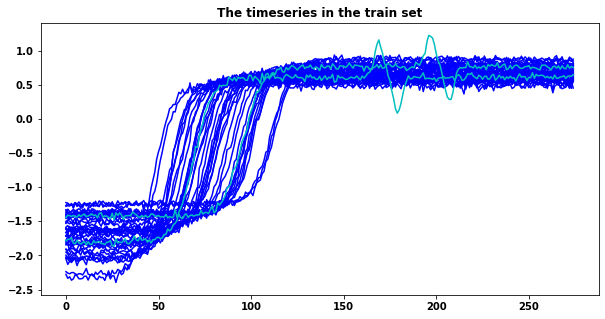

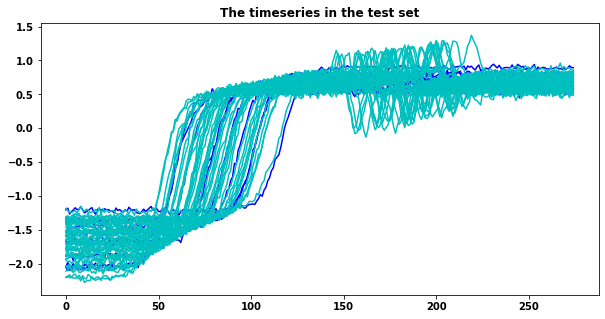

In [52]:
# only first channel in case multivariate
colors = ['r', 'b', 'g', 'y', 'c']

plt.figure(1, figsize=(10, 5))
for ts, label in zip(X_train_anomaly[:,:,0], y_train_anomaly):
    plt.plot(range(len(ts)), ts, c=colors[label%len(colors)])
plt.title('The timeseries in the train set', fontweight="bold")
plt.show()

plt.figure(2, figsize=(10, 5))
for ts, label in zip(X_test_anomaly[:,:,0], y_test_anomaly):
    plt.plot(range(len(ts)), ts, c=colors[label%len(colors)])
plt.title('The timeseries in the test set', fontweight="bold")
plt.show()


## Extract the shapelets from data subsequences

Set up the RLS extractor and hyperparameters:
- K_star: number of shapelets in proportion to length of time series Q
- L_min, L_max: range of shapelets' lengths
- r: number of candidates to be selected randomly for calculating scores at the beginning (should be not too small)
- m: best candidates to take in order to perform LocalSearch in their neighborhood
- beta: percentage of neighbors to eliminate (not compute scores) each time a neighborhood is found 
- epsilon: 
- reverse: bool, whether to take the shapelets with max (True) or min score

In [55]:
# SET THE PARAMETERS
extractor = RLS_extractor(train_data=X_train_anomaly, test_data=X_test_anomaly)
N, Q = extractor.data.shape[0:2]
K_star = 2 /Q
K = round(K_star*Q)

# range of lengths! 

L_min = 55
L_max = 55
r = 100
m = 3
pos_boundary = 7
reverse = True
epsilon = (2,1)
beta = 0.7 # eliminate beta% of neighbors

Extract the optimal shapelets:

In [56]:
# EXTRACT THE SHAPELETS
shapelets = extractor.extract(r, m, L_min, L_max, pos_boundary, epsilon, beta, reverse, K_star)

shapelets.scores
shapelets.positions
shapelets.lengths
len(shapelets.sequences[0])


# check that the sum of scored + not scored is equal to the total number of candidates

print('Number candidates scored', len(extractor.candidates_scored))
print('Number candidates not scored', len(extractor.candidates_notscored))
sum = len(extractor.candidates_scored) + len(extractor.candidates_notscored)
print('Their sum', sum)

total=0
for l in range(L_min, L_max+1):
    total+=N*(Q-l+1)

print('It should be', total)
print('They are equal:', total==sum)
# np.save(f'../Results/{data_name}/s_class34_reverse={reverse}_pos={pos_boundary}', S)
print(f'Positions of the shapelets {shapelets.positions}')
print(f'Scores {shapelets.scores}')

Are going to be extracted 2.000 shapelets of lengths between 55.0000 and 55.00000
Shapelets are going to be extracted in reverse order!
the length of the total random sample should be equal to r 100
Finished to get random candidates
Calculating scores


100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


finished to get top 3 candidates
Starting the local search
Searching in sequence number 0 neighbors


100%|██████████| 35/35 [00:30<00:00,  1.13it/s]


Searching in sequence number 1 neighbors


100%|██████████| 62/62 [00:55<00:00,  1.13it/s]


Searching in sequence number 2 neighbors


100%|██████████| 19/19 [00:17<00:00,  1.07it/s]

finished local search
finished to get top 2 candidates
Time for shapelets extraction:
--- 467.70829725265503 seconds ---
Number candidates scored 496
Number candidates not scored 8786
Their sum 9282
It should be 9282
They are equal: True
Positions of the shapelets [ 20 127]
Scores [0.05269681 0.03463518]


Plot the shapelets:

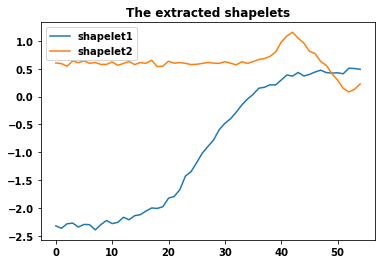

In [57]:
S = shapelets.sequences
channel = 0
plt.figure()
for i in range(len(S)):
    shap = S[i]
    plt.plot(shap[:,channel], label=f'shapelet{i+1}')
plt.legend()
plt.title('The extracted shapelets', fontweight="bold")
plt.show()

Transform the dataset:

In [58]:
# transform both train and test 
X_train_transform, X_test_transform = extractor.transform()
print('Type and shape of transformed train data', type(X_train_transform),  X_train_transform.shape)
print('Type and shape of transformed test data', type(X_test_transform),  X_test_transform.shape)

Type and shape of transformed train data <class 'numpy.ndarray'> (42, 2)
Type and shape of transformed test data <class 'numpy.ndarray'> (58, 2)


## Anomaly detection using SVDD/OCSVM

Choose how many extracted shapelets to take (2 for visualization purposes):

In [59]:
K = round(K_star*Q)
print('The maximum number of shapelets that can be taken is', K)
n_shap = 2 # n_shap must be <= K
X_train_transform = X_train_transform[:,0:n_shap]
X_test_transform = X_test_transform[:,0:n_shap]

The maximum number of shapelets that can be taken is 2


In [60]:
# nu is the proportion of anomalies w.r.t. the total
nu = np.around(len(y_train_anomaly[y_train_anomaly==-1])/len(y_train_anomaly), 3)
print(nu)

0.048


Fit the OCSVM in transformed space:

In [61]:
ocsvm = OneClassSVM(nu=nu, kernel='linear')

# fit the model
ocsvm.fit(X_train_transform)

OneClassSVM(kernel='linear', nu=0.048)

EVALUATE the prediction:

In [62]:
## TRAIN
# BALANCED ACCURACY
y_train_predict = ocsvm.predict(X_train_transform)
train_ba = balanced_accuracy_score(y_train_anomaly, y_train_predict)
print("OCSVM train balanced accuracy:", train_ba)

# AUC
y_train_scores = ocsvm.decision_function(X_train_transform)
auc_train = roc_auc_score(y_train_anomaly, y_train_scores)
print("OCSVM train AUC:", auc_train)

# F1 score
f1_train = f1_score(y_train_anomaly, y_train_predict)
print("OCSVM train F1 score:", f1_train)

## TEST
# BALANCED ACCURACY
y_test_predict = ocsvm.predict(X_test_transform)
test_ba = balanced_accuracy_score(y_test_anomaly, y_test_predict)
print("OCSVM test balanced accuracy:", test_ba)

# AUC
y_test_scores = ocsvm.decision_function(X_test_transform)
auc_test = roc_auc_score(y_test_anomaly, y_test_scores)
print("OCSVM test AUC:", auc_test)

# F1 score
f1_test = f1_score(y_test_anomaly, y_test_predict)
print("OCSVM test F1 score:", f1_test)

OCSVM train balanced accuracy: 0.7375
OCSVM train AUC: 0.8999999999999999
OCSVM train F1 score: 0.975
OCSVM test balanced accuracy: 0.6875
OCSVM test AUC: 0.9562499999999999
OCSVM test F1 score: 0.4


Confusion matrix

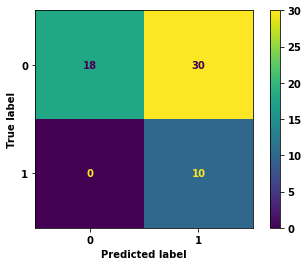

In [63]:
# Confusion matrix for test 
cm = confusion_matrix(y_test_anomaly, y_test_predict)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

ROC and overlapping histograms plot

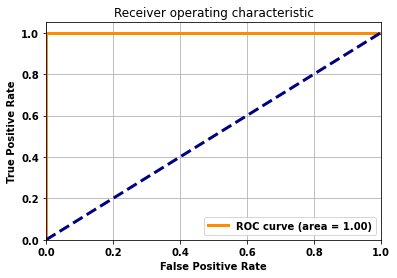

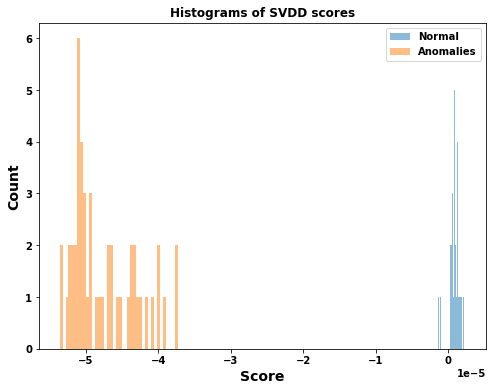

In [ ]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test_anomaly, y_test_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=3, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.show()
# plt.savefig('ROC_test.png')

# OVERLAPPING HISTOGRAMS PLOT of SVDD scores (test data)

plt.figure(figsize=(8,6))
plt.hist(y_test_scores[y_test_anomaly==1], bins=40, alpha=0.5, label="Normal")
plt.hist(y_test_scores[y_test_anomaly==-1], bins=40, alpha=0.5, label="Anomalies")

plt.xlabel("Score", size=14)
plt.ylabel("Count", size=14)
plt.title("Histograms of SVDD scores", fontweight="bold")
plt.legend(loc='upper right')
plt.show()

### PLOTS (first two coordinates in shapelet transformed space):

NOTE: if were taken more than 2 shapelets the SVDD boundaries are plotted but they do not indicate the correct boundary in the true points in greater dimension (the points are collapsed in the plane as if their other coordinates were equal to zero)

TRAIN DATA and SVDD boundary

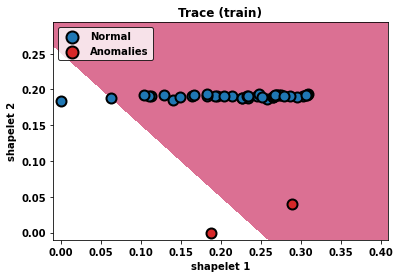

In [64]:
x_max = max(X_train_transform[:,0])+0.1
y_max = max(X_train_transform[:,1])+0.1
xx, yy = np.meshgrid(np.linspace(-0.1, x_max, 500), np.linspace(-0.1, y_max, 500))
Z = ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
pIndex_train = y_train_anomaly == 1
nIndex_train = y_train_anomaly == -1


plt.figure()
plt.title(f"{data_name} (train)", fontweight="bold")

plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")
plt.scatter(X_train_transform[pIndex_train, 0], X_train_transform[pIndex_train, 1], facecolor='C0', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Normal")

plt.scatter(X_train_transform[nIndex_train, 0], X_train_transform[nIndex_train, 1], facecolor='C3', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Anomalies")

plt.legend(ncol=1, loc='upper left', edgecolor='black',
                    markerscale=1.2, fancybox=True)
plt.xlim((-0.01, x_max))
plt.ylim((-0.01, y_max))
plt.ylabel("shapelet 2")
plt.xlabel("shapelet 1")
plt.show()

TEST DATA and SVDD boundary

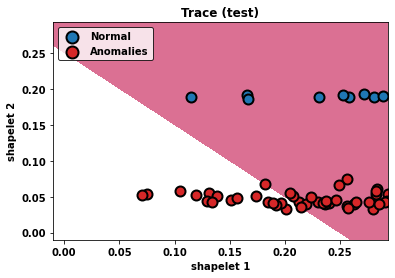

In [65]:
x_max = max(X_test_transform[:,0])+0.1
y_max = max(X_test_transform[:,1])+0.1
xx, yy = np.meshgrid(np.linspace(-0.1, x_max, 500), np.linspace(-0.1, y_max, 500))
Z = ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
pIndex_test = y_test_anomaly == 1
nIndex_test = y_test_anomaly == -1
auc_test = np.around(auc_test, 3)
plt.figure()
plt.title(f"{data_name} (test)", fontweight="bold")

plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")
plt.scatter(X_test_transform[pIndex_test, 0], X_test_transform[pIndex_test, 1], facecolor='C0', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Normal")

plt.scatter(X_test_transform[nIndex_test, 0], X_test_transform[nIndex_test, 1], facecolor='C3', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Anomalies")

plt.legend(ncol=1, loc='upper left', edgecolor='black',
                     markerscale=1.2, fancybox=True)

plt.xlim((-0.01, y_max))
plt.ylim((-0.01, y_max))
plt.ylabel("shapelet 2")
plt.xlabel("shapelet 1")
plt.show()